In [1]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [ ]:
# Get the certain STL 10 Data
# from skimage import util 
# data_location = "../../Dataset/STL10/img/2/"
# train_data = []  # create an empty list
# for dirName, subdirList, fileList in sorted(os.walk(data_location)):
#     for filename in fileList:
#         if ".png" in filename.lower() :
#             train_data.append(os.path.join(dirName,filename))

# image_resize_px = 64
# train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
# for file_index in range(len(train_data)):
#     train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))
            
# # print out the data shape and the max and min value
# train_batch = np.expand_dims(train_batch,3)
# print('Train batch, min, max : ',train_batch.shape,train_batch.min(),train_batch.max())

In [5]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/FashionMNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((60000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(x_data)):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)
for x in range(len(y_data)):
    test_batch[x,:,:,:] = np.expand_dims(resize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/FashionMNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/FashionMNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/FashionMNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/FashionMNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(60000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
1.0
0.0
(10000, 10)
1.0
0.0


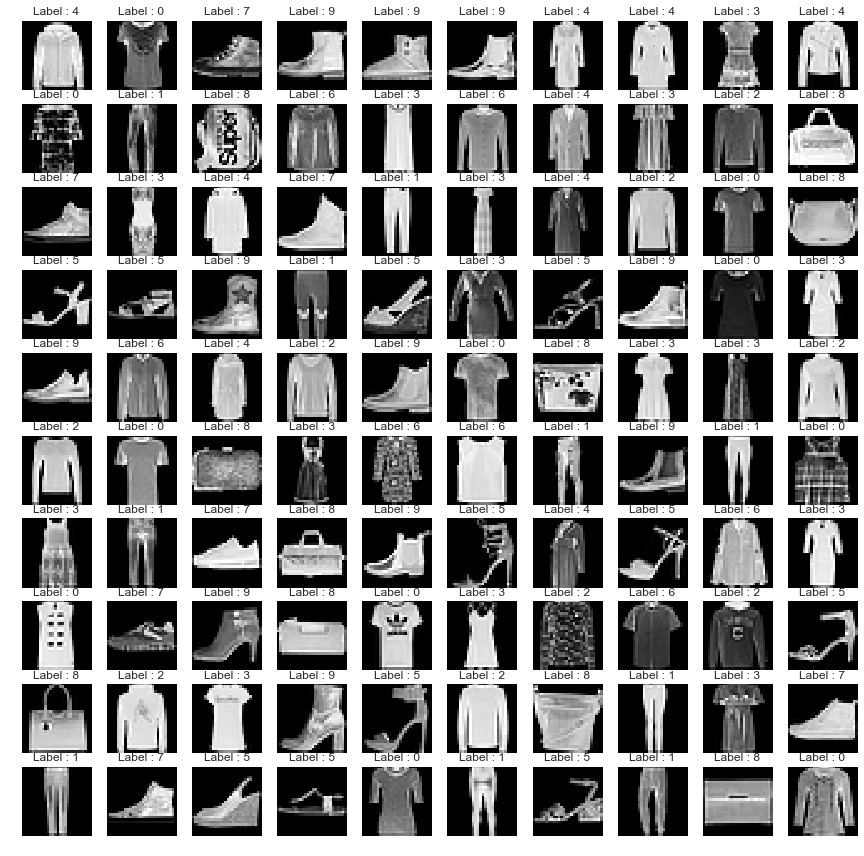

In [10]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [164]:
#  import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class CNN():
    """Convolutional Layer in Tensorflow

    Parameters
    ----------
    k : type
        Description of parameter `k`.
    inc : type
        Description of parameter `inc`.
    out : type
        Description of parameter `out`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

class CNN_Trans():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input,output_shape,stride=1,padding='SAME'):
        self.input   = input
        self.layer  = tf.nn.conv2d_transpose(
            input,self.w,output_shape=[batch_size,output_shape,output_shape,self.w.shape[2].value],
            strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride_grad=1,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_middle,
            filter_sizes = self.w.shape,out_backprop = grad_part_3,
            strides=[1,stride_grad,stride_grad,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d(
            input=grad_middle,filter = self.w,strides=[1,stride,stride,1],padding=padding
        )

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))

        return grad_pass,update_w

In [165]:
# define classes hyper parameters and graph
num_epoch=60; learning_rate = 0.0008; batch_size = 100; print_size = 3
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(5,1,16) 
l2 = CNN(5,16,32) 
l3 = CNN(5,32,32)

l4 = CNN_Trans(5,32,32) 
l5 = CNN_Trans(5,16,32) 
l6 = CNN_Trans(5,1,16,act=tf_sigmoid,d_act=d_tf_sigmoid)

x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float64)

layer1 = l1.feedforward(x,padding='VALID')
layer2 = l2.feedforward(layer1,padding='VALID')
layer3 = l3.feedforward(layer2,padding='VALID')

layer4 = l4.feedforward(layer3,padding='VALID',output_shape=20)
layer5 = l5.feedforward(layer4,padding='VALID',output_shape=24)
layer6 = l6.feedforward(layer5,padding='VALID',output_shape=28)

recont_loss = tf.reduce_mean(tf.square(layer6-x))

grad_6,grad_6_up = l6.backprop(layer6-x,padding='VALID')
grad_5,grad_5_up = l5.backprop(grad_6,padding='VALID')
grad_4,grad_4_up = l4.backprop(grad_5,padding='VALID')

grad_3,grad_3_up = l3.backprop(grad_4,padding='VALID')
grad_2,grad_2_up = l2.backprop(grad_3,padding='VALID')
grad_1,grad_1_up = l1.backprop(grad_2,padding='VALID')
grad_up = grad_6_up+grad_5_up+grad_4_up+grad_3_up + grad_2_up + grad_1_up

(60000, 28, 28, 1)
iter : 0 index: 59900 recon mean: 0.009293252707944705
----------


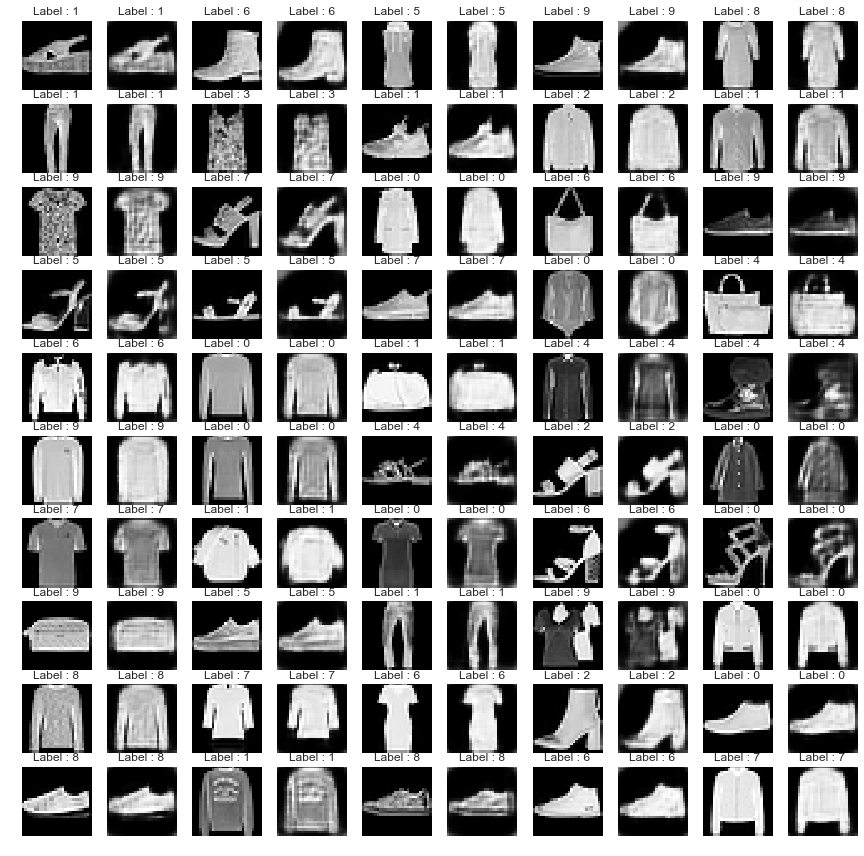

iter : 3 index: 59900 recon mean: 0.0044968326757057265
----------


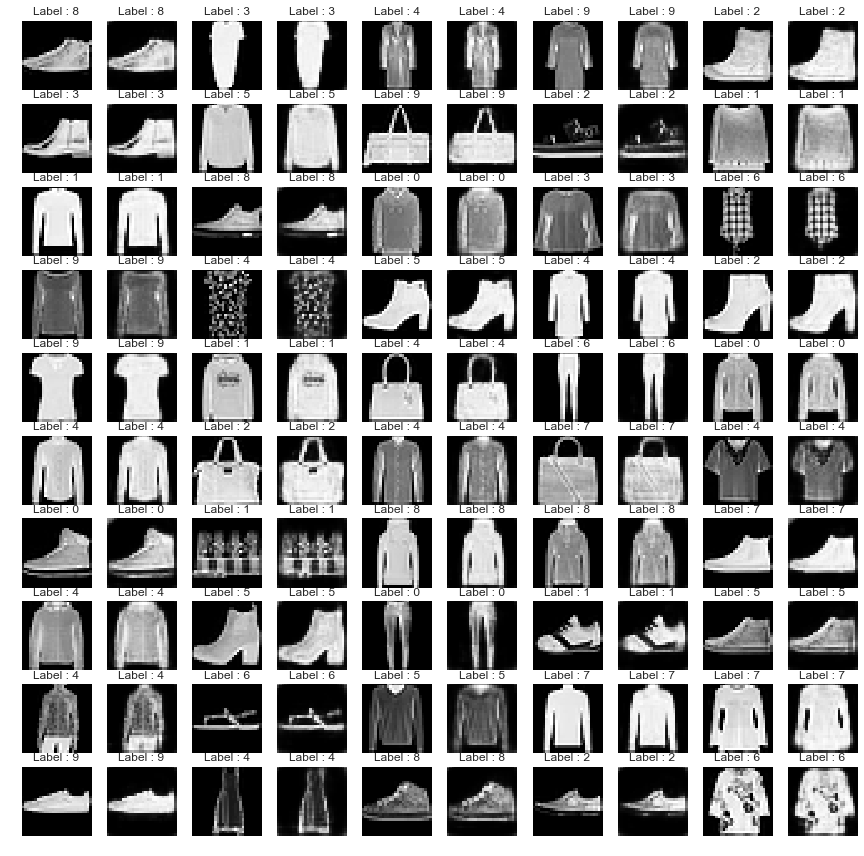

iter : 6 index: 59900 recon mean: 0.0030037132989376917
----------


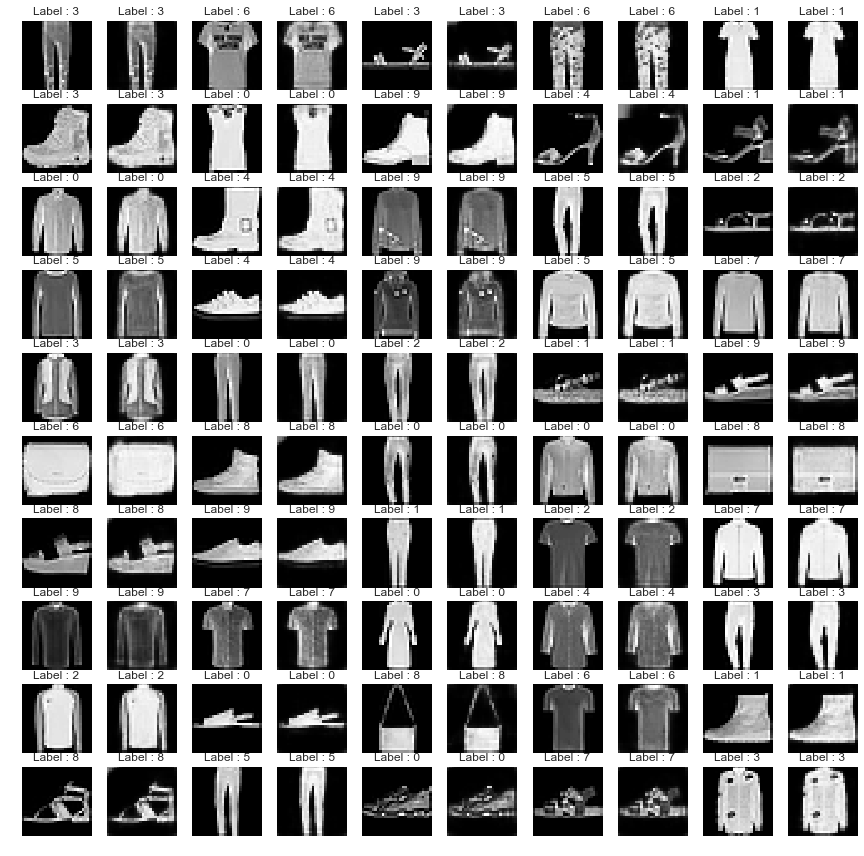

iter : 9 index: 59900 recon mean: 0.0025713352970628696
----------


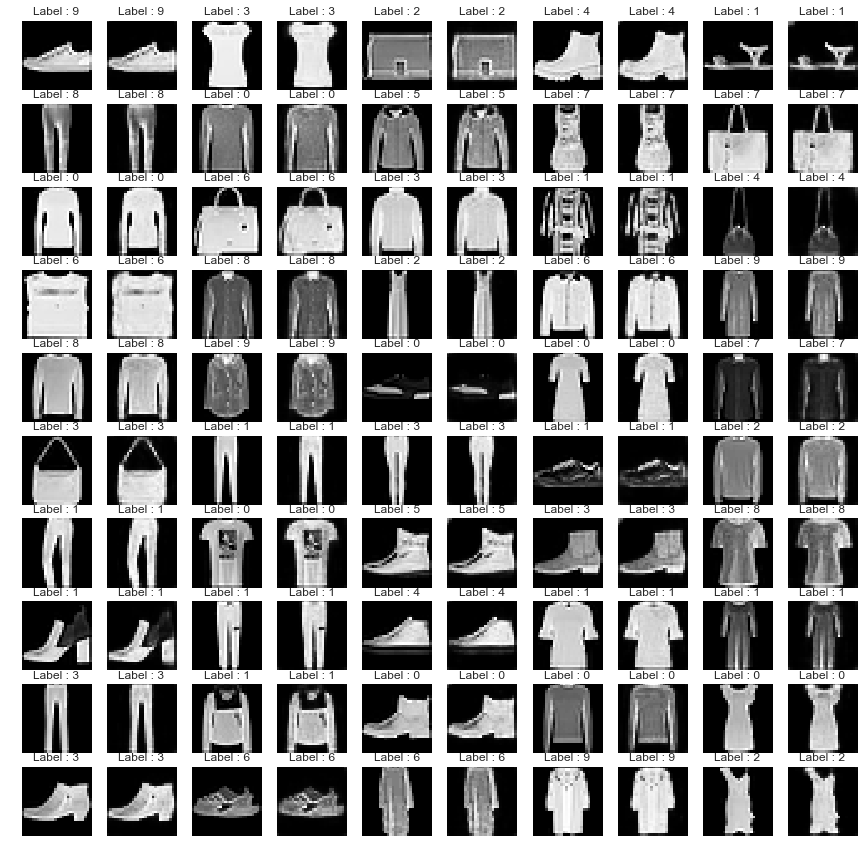

iter : 12 index: 59900 recon mean: 0.0021076589839684997
----------


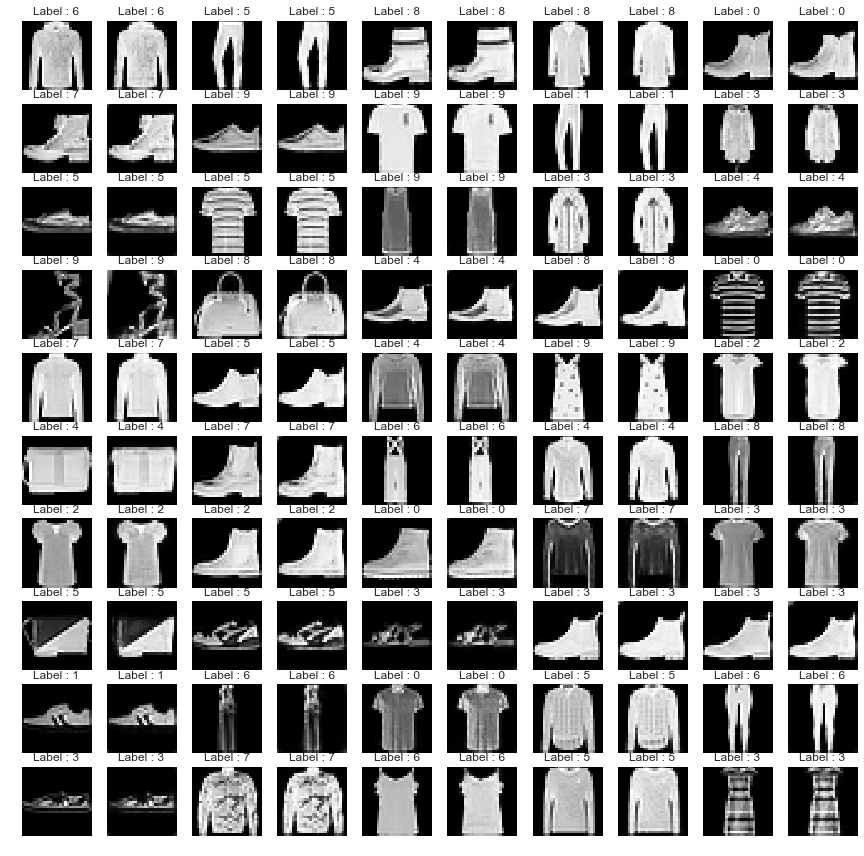

iter : 15 index: 59900 recon mean: 0.0018062221813715052
----------


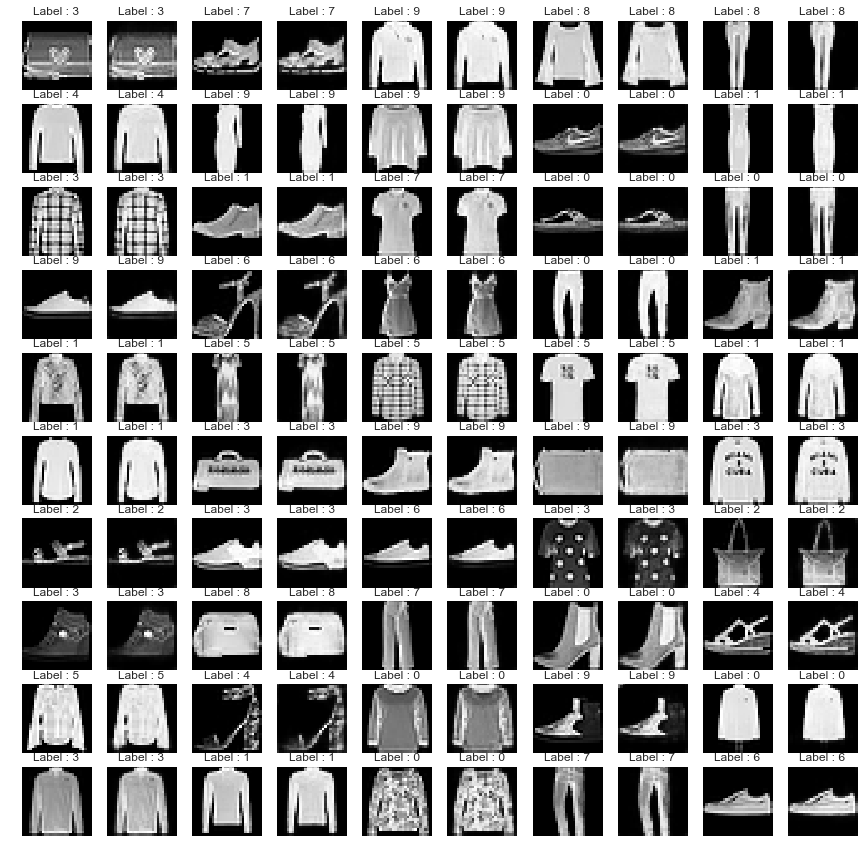

iter : 18 index: 59900 recon mean: 0.0012814879306492805
----------


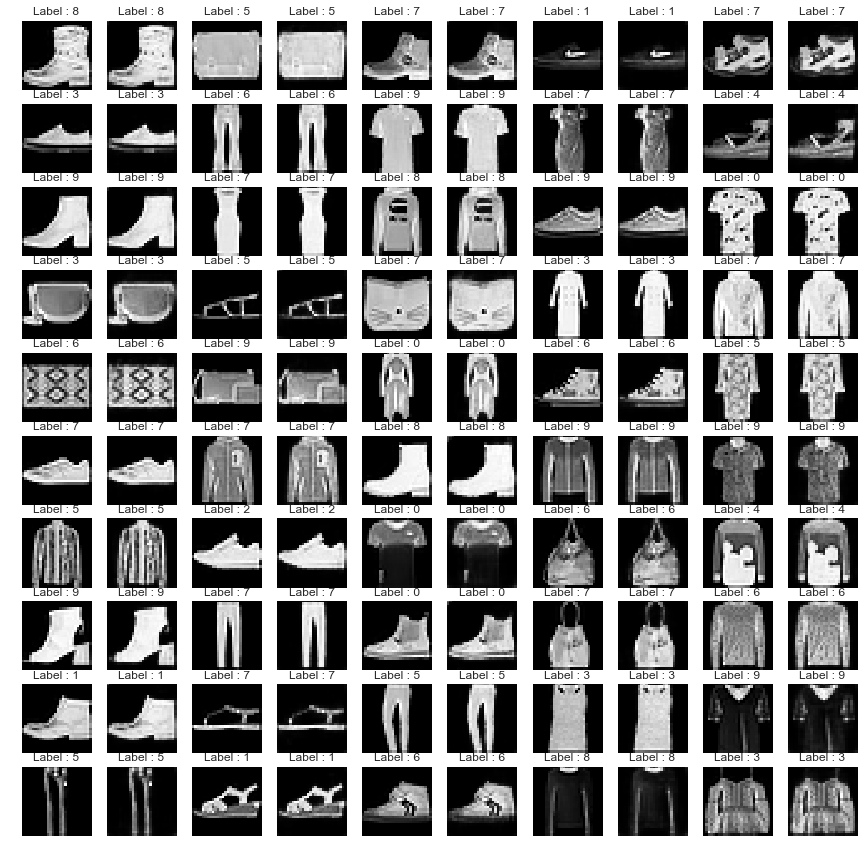

iter : 21 index: 59900 recon mean: 0.0012403107677976577
----------


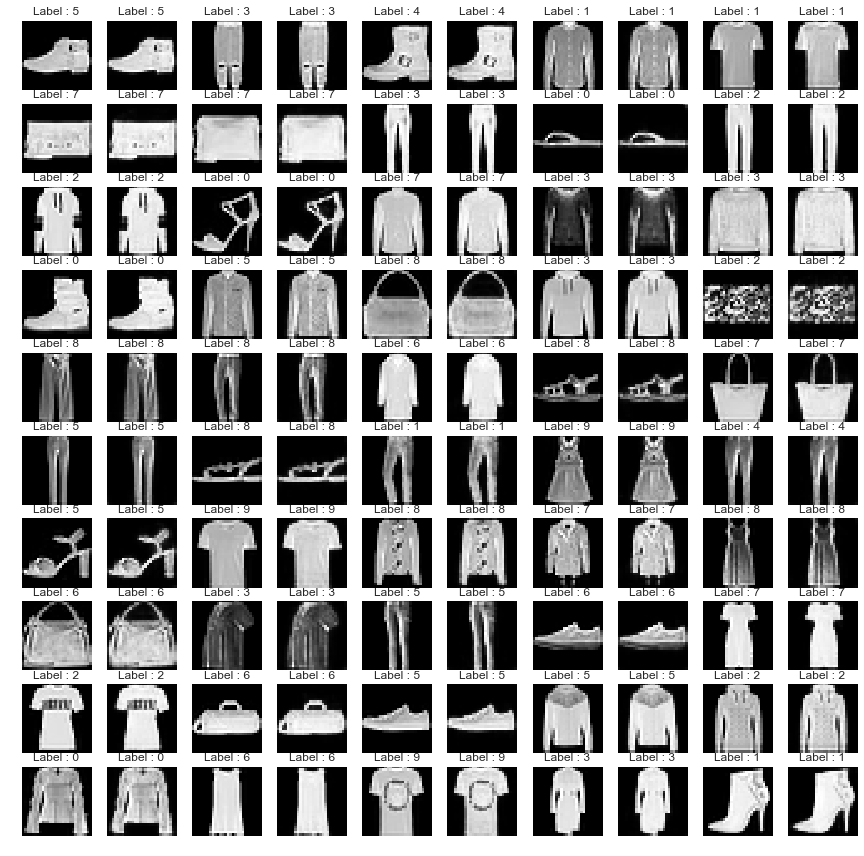

iter : 24 index: 59900 recon mean: 0.0011505313374883573
----------


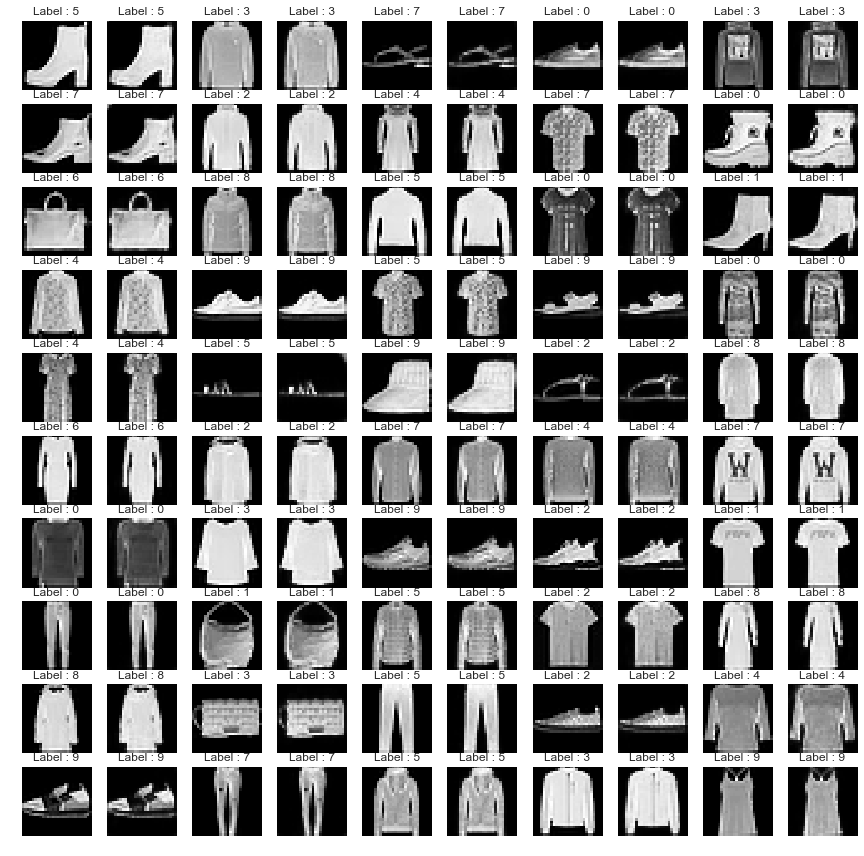

iter : 27 index: 59900 recon mean: 0.0011624509420018652
----------


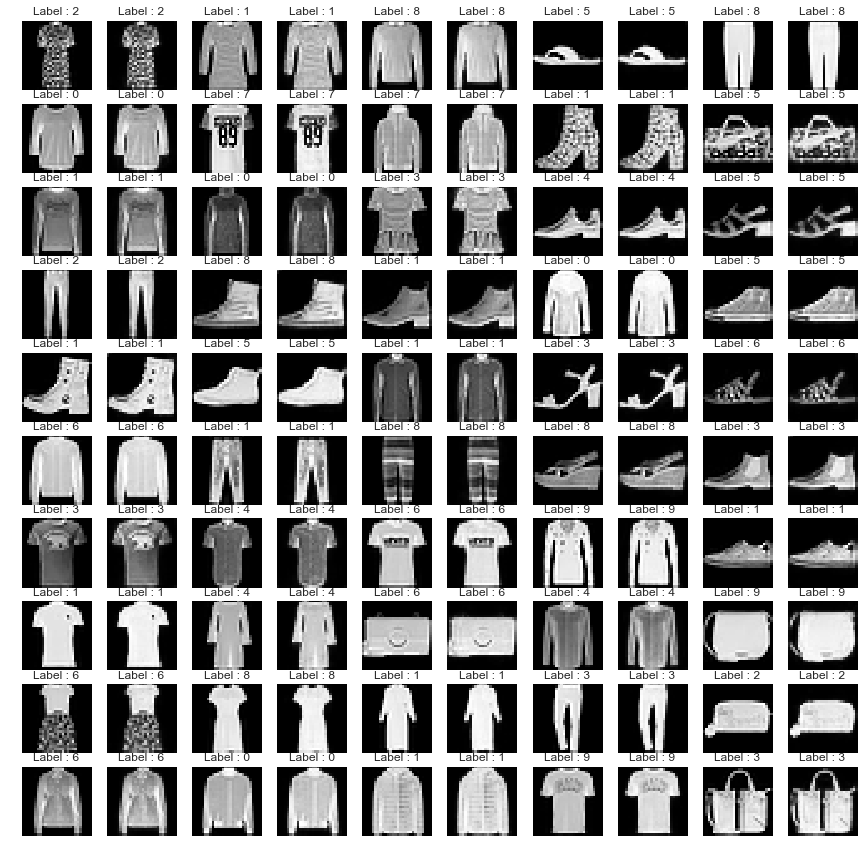

iter : 30 index: 59900 recon mean: 0.0012000470061281667
----------


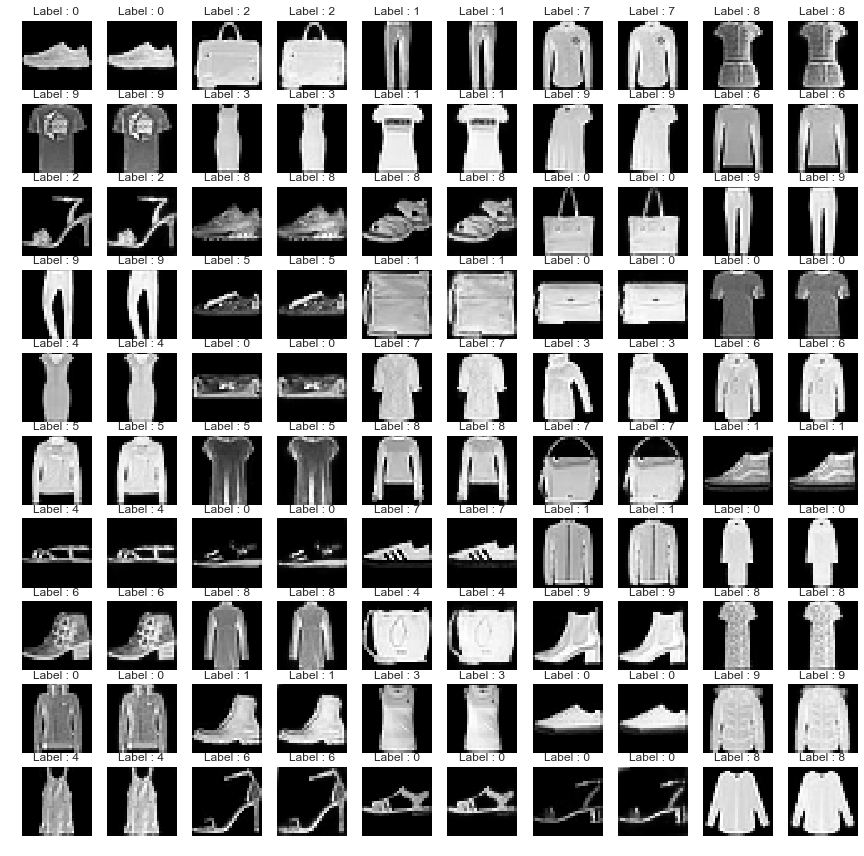

iter : 33 index: 59900 recon mean: 0.0010643305456463684
----------


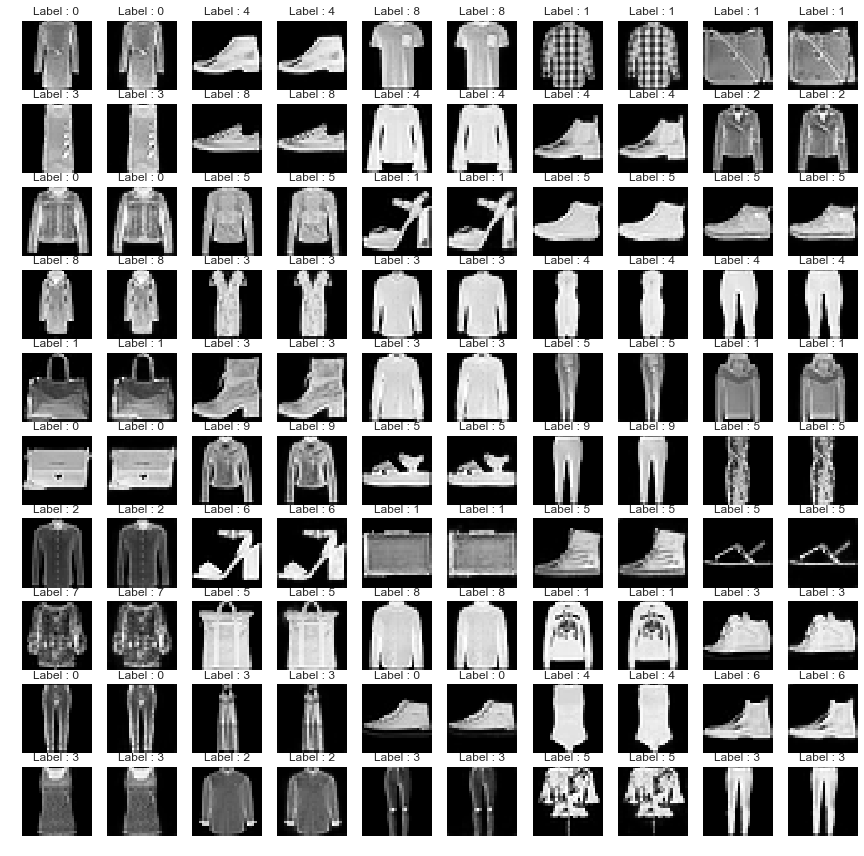

iter : 36 index: 59900 recon mean: 0.0012842711589020998
----------


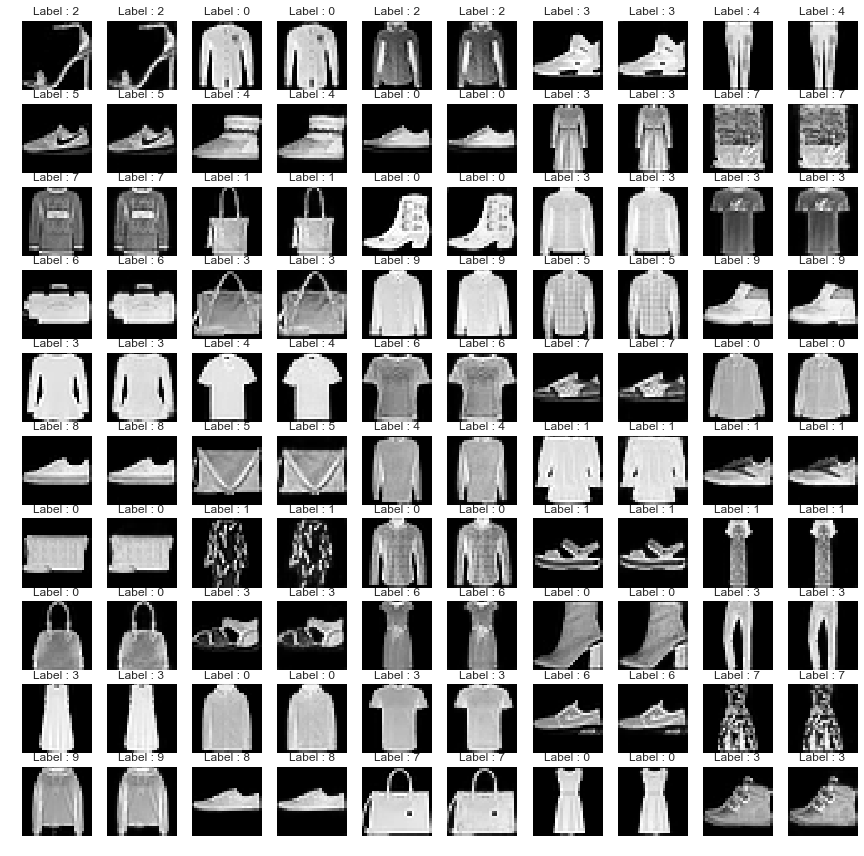

iter : 39 index: 59900 recon mean: 0.0006894608122330447
----------


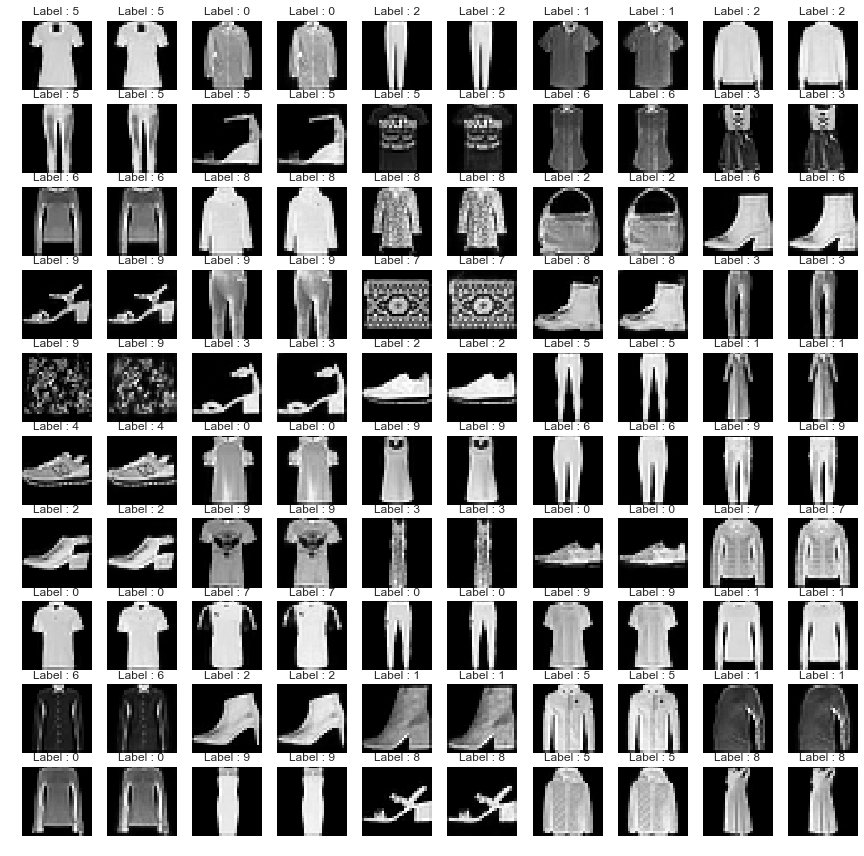

iter : 42 index: 59900 recon mean: 0.0009576669072904179
----------


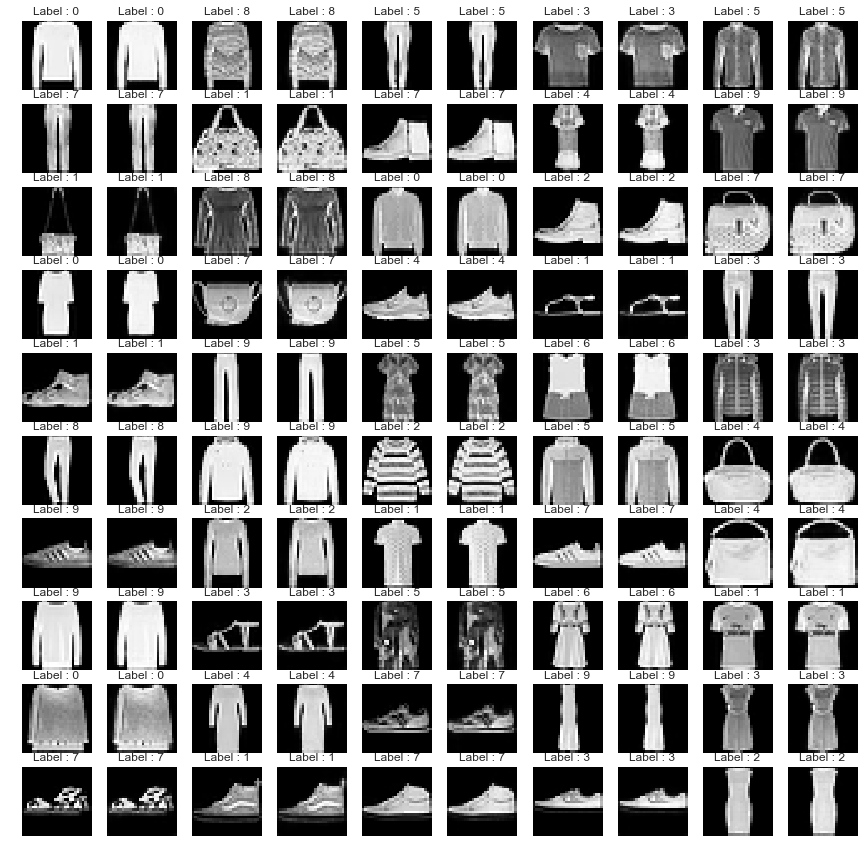

iter : 45 index: 59900 recon mean: 0.0007096377189704839
----------


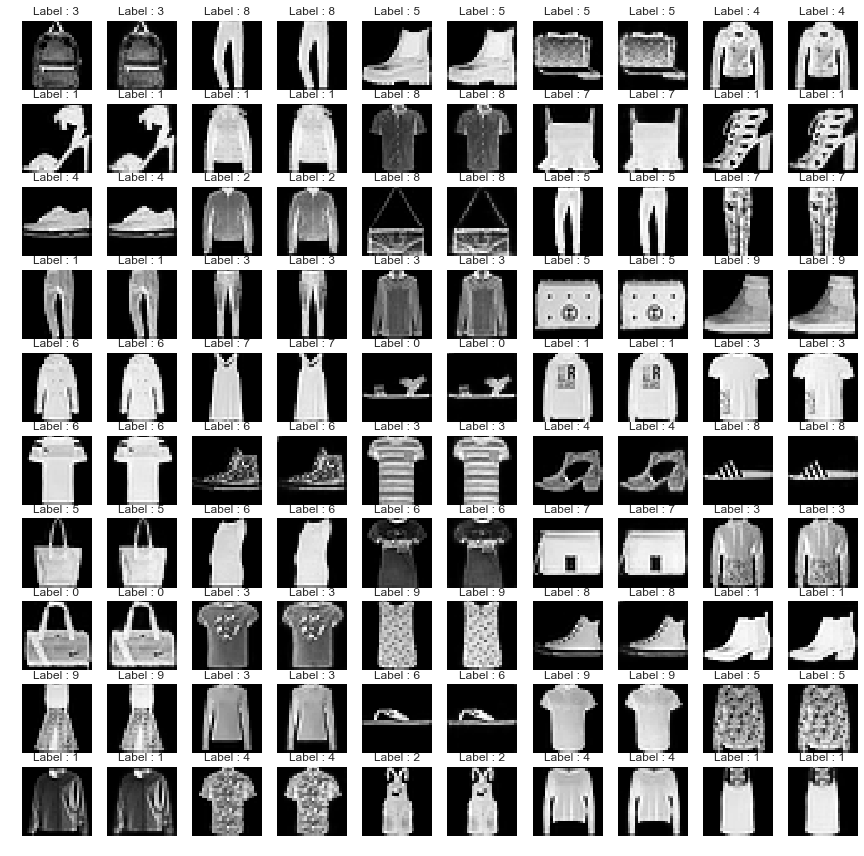

iter : 48 index: 59900 recon mean: 0.0010040105177182102
----------


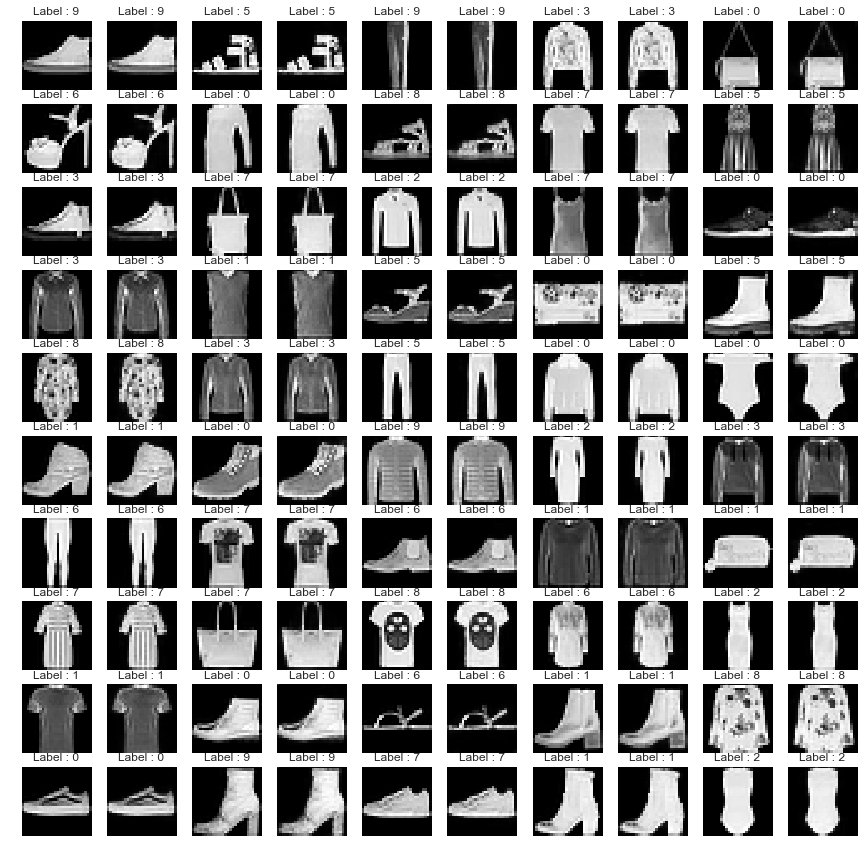

iter : 51 index: 59900 recon mean: 0.0007926611970733449
----------


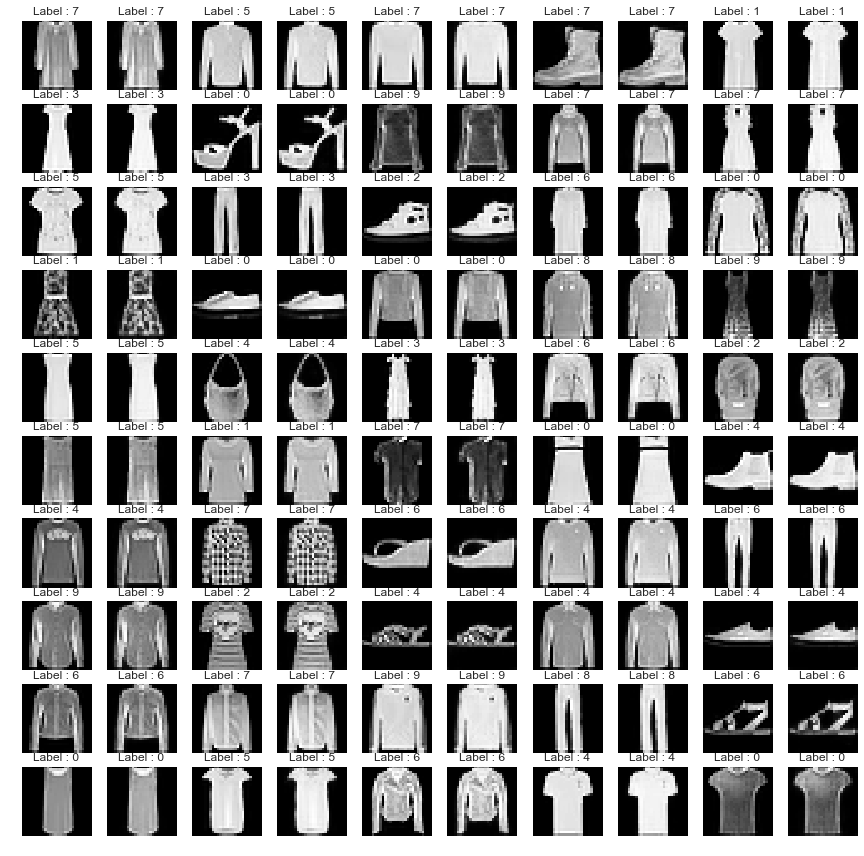

iter : 54 index: 59900 recon mean: 0.0010664159243641222
----------


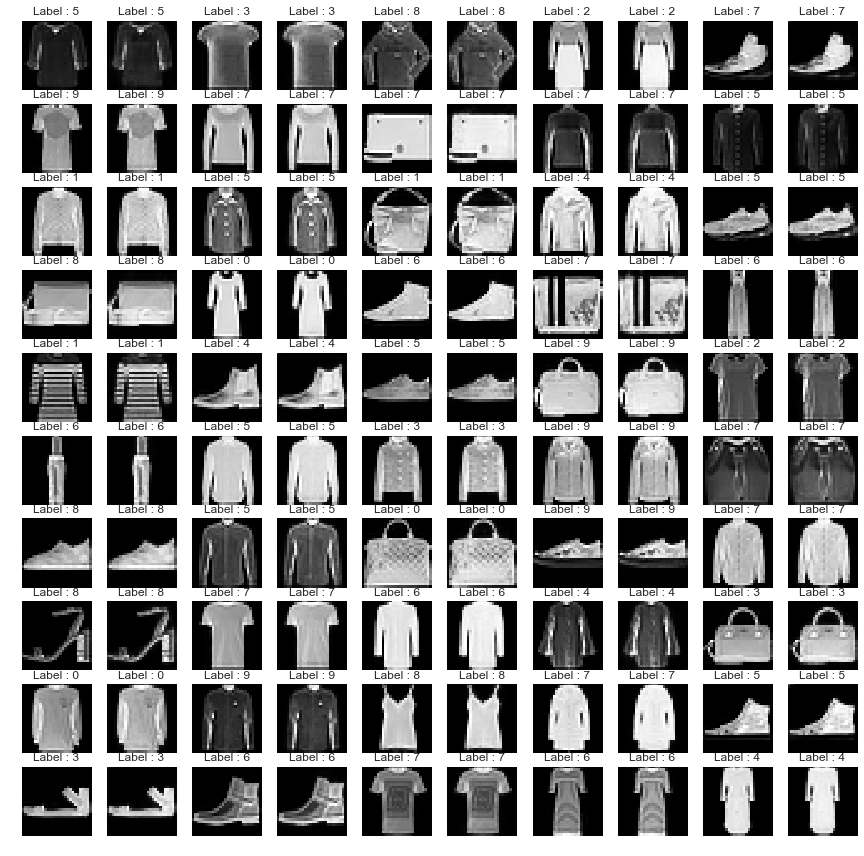

iter : 57 index: 59900 recon mean: 0.0006626082838906993
----------


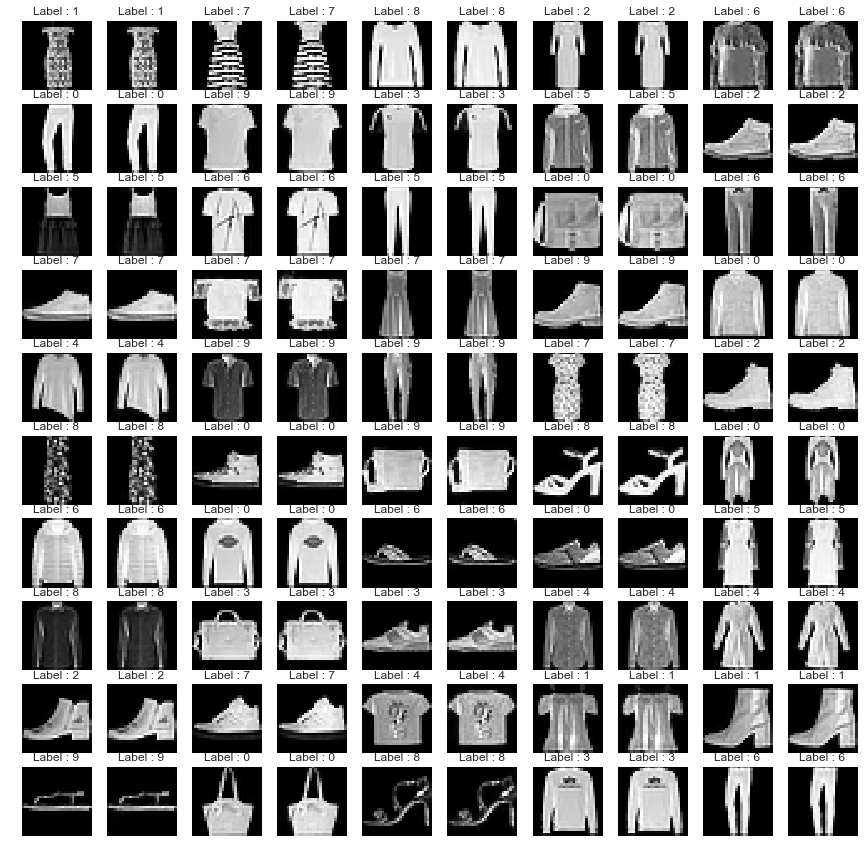

iter : 59 index: 27000 recon mean: 0.0008869555412966353

In [ ]:
# start the session
print(train_batch.shape)
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for iter in range(num_epoch):
    
    train_batch,train_label = shuffle(train_batch,train_label)
    
    for current_batch_index in range(0,len(train_batch), batch_size):
        current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
        sess_results = sess.run([recont_loss,grad_up],feed_dict={x:current_train_data})
        sys.stdout.write("\r" + 
                         'iter : ' + str(iter) + 
                         ' index: '+ str(current_batch_index) +
                         " recon mean: " + str(sess_results[0]) ) 
        sys.stdout.flush()
        
    # show mid results     
    if iter % print_size == 0: 
        print('\n----------')
        sample_data = sess.run(layer6,feed_dict={x:current_train_data})
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 10
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 == 0 :
                plt.imshow(np.squeeze(sample_data[i-2]),cmap='gray')
                plt.title("Label : "+str(np.argmax(train_label[i-2])))
            else:
                plt.imshow(np.squeeze(current_train_data[i-1]),cmap='gray')
                plt.title("Label : "+str(np.argmax(train_label[i-1])))
            plt.axis('off')
        plt.show()

In [ ]:
# project all of the data into latent

In [ ]:
#  use high level tsne to view the data

In [ ]:
# create additional graph to create strange outputs (out from the distributions)

In [ ]:
! git all-go